In [9]:
from bert_feature_extraction_util import *

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics

import pandas as pd
import seaborn as sns
import numpy as np

from scipy.stats import uniform

from tqdm import tqdm
tqdm.pandas()

In [4]:
train = pd.read_csv('../data/train.csv')
dev = pd.read_csv('../data/dev.csv')

In [5]:
encoder = BertEncoder()

In [6]:
X_train = train['text'].progress_apply(lambda x: encoder.encode(x)).to_list()
y_train = train['is_humor']

X_dev = dev['text'].progress_apply(lambda x: encoder.encode(x)).to_list()
y_dev = dev['is_humor']

100%|██████████| 800/800 [00:27<00:00, 29.45it/s]


In [15]:
start_c = 0.25
start_gamma = 0.001

c_params = []
gamma_params = []
f1_scores = []

f1_best = 0
c_best = 0
gamma_best = 0
model_best = None

iterations = 4

for i in range(iterations):
    c = start_c * 2 ** i
    for j in range(iterations):
        gamma = start_gamma * 2 ** j

        model = SVC(class_weight='balanced', C=c, gamma=gamma)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_dev)
        weighted_f1 = metrics.f1_score(y_dev, y_pred, average='weighted')
        if weighted_f1 > f1_best:
            f1_best = weighted_f1
            c_best = c
            gamma_best = gamma
            model_best = model

        gamma_params.append(gamma)
        c_params.append(c)
        f1_scores.append(weighted_f1)

<Axes: >

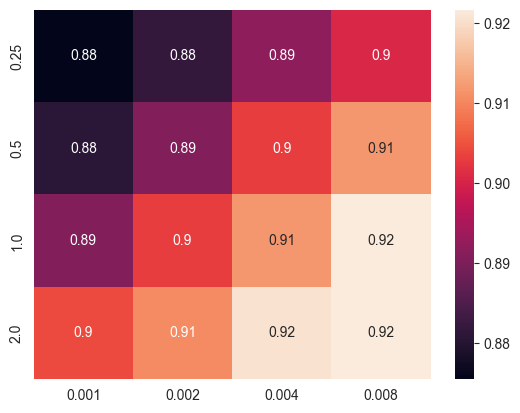

In [16]:
sns.heatmap(np.array(f1_scores).reshape(iterations, iterations),
            annot=True,
            xticklabels=[start_gamma * 2 ** i for i in range(iterations)],
            yticklabels=[start_c * 2 ** i for i in range(iterations)])

# Evaluation

In [15]:
test = pd.read_csv('../data/test.csv')

X_test = test['text'].progress_apply(lambda x: encoder.encode(x)).to_list()
y_test = test['is_humor']

100%|██████████| 800/800 [00:25<00:00, 30.86it/s]


In [22]:
y_pred = model_best.predict(X_test)

In [23]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       307
           1       0.93      0.93      0.93       493

    accuracy                           0.92       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.92      0.92      0.92       800


<Axes: >

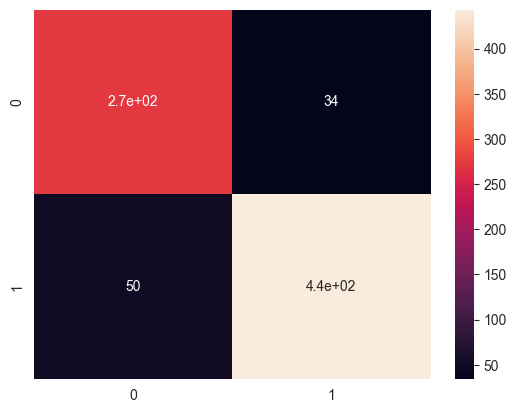

In [27]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True)

# Random search for hyperparameter tuning

In [29]:
distributions = dict(
    C = uniform(loc=0, scale=5),
    gamma = uniform(loc=0, scale=0.25)
)

classifier = RandomizedSearchCV(SVC(class_weight='balanced'), 
                                distributions, verbose=True)

In [30]:
classifier.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=SVC(class_weight='balanced'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16a4df9d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28817fc10>},
                   verbose=True)

In [31]:
classifier.best_params_

{'C': 3.335305212529967, 'gamma': 0.023222041502834412}

In [32]:
y_pred = classifier.predict(X_test)

In [33]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       307
           1       0.93      0.96      0.95       493

    accuracy                           0.94       800
   macro avg       0.94      0.93      0.93       800
weighted avg       0.94      0.94      0.93       800


<Axes: >

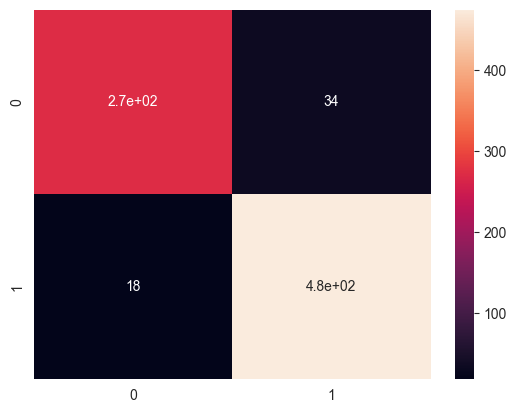

In [34]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True)